# Posterior Predictive Plots
Posterior predictive plots simulate replicated data under the fitted model and then compare them to the observed data (Gelman and Hill 2007). Using estimates from my Markov Chain Monte Carlo runs, I plot the best fit model with different combinations of initial conditions for effective temperature, surface gravity, radial velocity, reddening, and radius. Theoretically, against the real yellow supergiant data, this model should be a close fit.

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from termcolor import colored 
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
import cmasher as cmr
my_cmap = cmr.guppy
data_color = my_cmap(25)
emcee_color = my_cmap(170)
resid_color = my_cmap(75)

In [19]:
#grab anything that contains '.fits'
files = glob('*.fits')
mcfiles = glob('*emcee.h5')

# sort mcfiles to the order files is in
mcfiles_sorted = [] # create empty list
# iterate through each value in files and if they start the same add it to the 
# new list so that mcfiles is ordered the same as files
for j in range(len(files)): 
    for i in range(len(mcfiles)):
        mcfilehead=mcfiles[i][:-9]
        if files[j]==mcfilehead:
            mcfiles_sorted.append(mcfiles[i])
print(mcfiles_sorted)

['hd269879_122722.fits_emcee.h5', 'hd269857_122722.fits_emcee.h5', 'hd27005_122722.fits_emcee.h5', 'hd269723_122722.fits_emcee.h5', 'hd269662_122622.fits_emcee.h5', 'hd269070_122622.fits_emcee.h5', 'sk_69_99_122622.fits_emcee.h5', 'hd269697_122722.fits_emcee.h5', 'hd269902_122722.fits_emcee.h5', 'w60_d17_122622.fits_emcee.h5', 'hd269331_122622.fits_emcee.h5', 'hd269661_122622.fits_emcee.h5', 'hd268727_010323.fits_emcee.h5', 'hd269762_122722.fits_emcee.h5', 'hd269953_122722.fits_emcee.h5', 'hd33579_122622.fits_emcee.h5', 'hv2450_122622.fits_emcee.h5', 'hv883_010323.fits_emcee.h5', 'hd269604_122622.fits_emcee.h5', 'hd268819_122622.fits_emcee.h5', 'j05344_122722.fits_emcee.h5', 'cd_69_310_122622.fits_emcee.h5', 'sp77_31_16_122622.fits_emcee.h5', 'cpd-69-496_122722.fits_emcee.h5', 'hd269781_122722.fits_emcee.h5', 'hd268687_122622.fits_emcee.h5', 'sp77_48_6_122622.fits_emcee.h5', 'hd268828_010323.fits_emcee.h5', 'hd269651_122622.fits_emcee.h5', 'hd269982_122722.fits_emcee.h5', 'sk_69_148_12

In [4]:
def ssp(theta):
    """
    plots a stsynphot graph based on a theta that holds the values of t_eff, log_g, rv, ebv, radius
    """
    t_eff, log_g, rv, ebv, radius = theta # unpack theta
    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) # model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) # speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) # average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2
    
    return reddenedmodel_flux

In [5]:
def fitsfile(i):
    """
    Opens fits file and prints which file it is
    """
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i) + ' and named ' + hdr['OBJECT'], 'red', attrs=['bold'])  
    print(text)  
    #print(specdata)
    
    #print(spec1d)
    return spec1d, hdr
    

In [6]:
def smooth(i):
    """
    Smooths the data of file i so it is easier to fit the model to the data
    """
    spec1d, hdr = fitsfile(i)
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    return spec_interp, spec1d

In [7]:
def loademcee(i, toss):
    """
    reads the h5 file and generates theta values where theta is [t_eff, log_g, rv, ebv, radius]
    """
    # load the file
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_noise_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain(flat=True, discard=toss)
    return samples

# Plots
Code for plots.

In [8]:
def byeye(theta, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii) in theta
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array along with the smoothed data
    """

    reddenedmodel_flux = ssp(theta) # constructs stsynphot model based on theta
    spec_interp, spec1d = smooth(i)
    
    
    ax = plt.subplots()[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
#     diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
#     print(diff)

In [34]:
def postpred(wavelength, i, toss=1000):
    """
    Takes an array of wavelength points and graph number i and 
    outputs corresponding emcee model flux evaluated on the wavelength array along with the smoothed data. 
    (posterior predictive plot)
    """
    # unpack values from smoothed data and loademcee
    spec_interp, spec1d = smooth(i)
    samples = loademcee(i, toss=toss) # unpack
    
    #label
    emceeline = Line2D([0], [0], label='emcee', color=emcee_color)
    smoothline = Line2D([0], [0], label='smoothed data', color=data_color)
    
    ax = plt.subplots(dpi=300)[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value, lw=2, color=data_color) # smooth
    ax.set_xlim(3000,9700)
    ax.set_ylabel('Flux (erg/s/cm^2/Å)', fontsize = 15)
    ax.set_xlabel('Wavelength (Å)', fontsize = 15)

    # plot emcee generated parameters within the given error bars 32 times
    rand_ind=np.random.randint(0,127999, size=32)
    label = 'emcee' #(wavelength, reddenedmodel_flux, alpha=1, label='emcee', color='black')
    for i in rand_ind: #choose random thetas
        theta = samples[i]
        reddenedmodel_flux = ssp(theta)
        plt.plot(wavelength, reddenedmodel_flux, alpha=.05, color=emcee_color)
    
    
    plt.show
    ax.legend(loc='lower right', handles=[emceeline, smoothline])

In [10]:
def cornerplot(i, toss=1000):
    """
    Plots corner plot for index i in the array of mcfiles_sorted
    """
    samples = loademcee(i, toss=toss) # unpack
    
    # give axes labels
    labels = ['t_eff', 'log_g', 'rv', 'ebv', 'radius']
    
    # plot
    fig = corner.corner(samples, labels=labels)
    axes = np.array(fig.axes).reshape(5,5)
    
    for ax in axes.flatten():
        # change size of axes
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        ax.title.set_size(16)
        # change size of ticks
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)

In [11]:
def trace(i):
    """
    Makes trace graph based on the emcee run in the index i of the 'mcfiles_sorted' array
    """
    reader = emcee.backends.HDFBackend('/Users/kchen/FYPS/' + mcfiles_sorted[i], name='rv_noise_prior')
    #discard first 1000 points where it's converging
    samples = reader.get_chain()
    
    fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
    nfsamples = reader.get_chain()
    labels = ["t_eff", "log_g", "rv", "ebv", "radius"]
    for j in range(5):
        ax = axes[j]
        ax.plot(nfsamples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(nfsamples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

In [12]:
def mcvalues(i, toss=1000):
    """
    Prints emcee's guesses of parameters t_eff, log_g, rv, ebv, and radius with an error of 2 standard deviations
    for the index i of 'mcfiles_sorted'
    """
    labels = ['t_eff', 'log_g', 'rv', 'ebv', 'radius']
    samples = loademcee(i, toss=toss) # unpack
    for i in range(5):
        mcmc = np.percentile(samples[:,i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        print(txt)
    

# Testing HD269723
We can test these functions using one star in my sample, HD269723.

In [13]:
import pandas as pd
df = pd.read_csv('/Users/kchen/Downloads/ysg.csv') # read csv
# calculate t_eff, log(g), radial velocity, reddening, radius
mcvalues(24)
mcvalues(35)

\mathrm{t_eff} = 7493.417_{-4.755}^{4.438}
\mathrm{log_g} = 2.999_{-0.001}^{0.000}
\mathrm{rv} = -465.798_{-13.775}^{12.541}
\mathrm{ebv} = 0.000_{-0.000}^{0.000}
\mathrm{radius} = 229.184_{-0.192}^{0.208}
\mathrm{t_eff} = 5115.426_{-5.959}^{6.120}
\mathrm{log_g} = 0.774_{-0.072}^{0.070}
\mathrm{rv} = 66.489_{-20.598}^{20.785}
\mathrm{ebv} = 0.000_{-0.000}^{0.001}
\mathrm{radius} = 375.429_{-1.168}^{1.148}


/var/folders/c4/wt3q5wqs15q2_09lr7xm4tnc0000gs/T/ipykernel_4085/627599240.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(12)
/var/folders/c4/wt3q5wqs15q2_09lr7xm4tnc0000gs/T/ipykernel_4085/627599240.py:23: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(12)


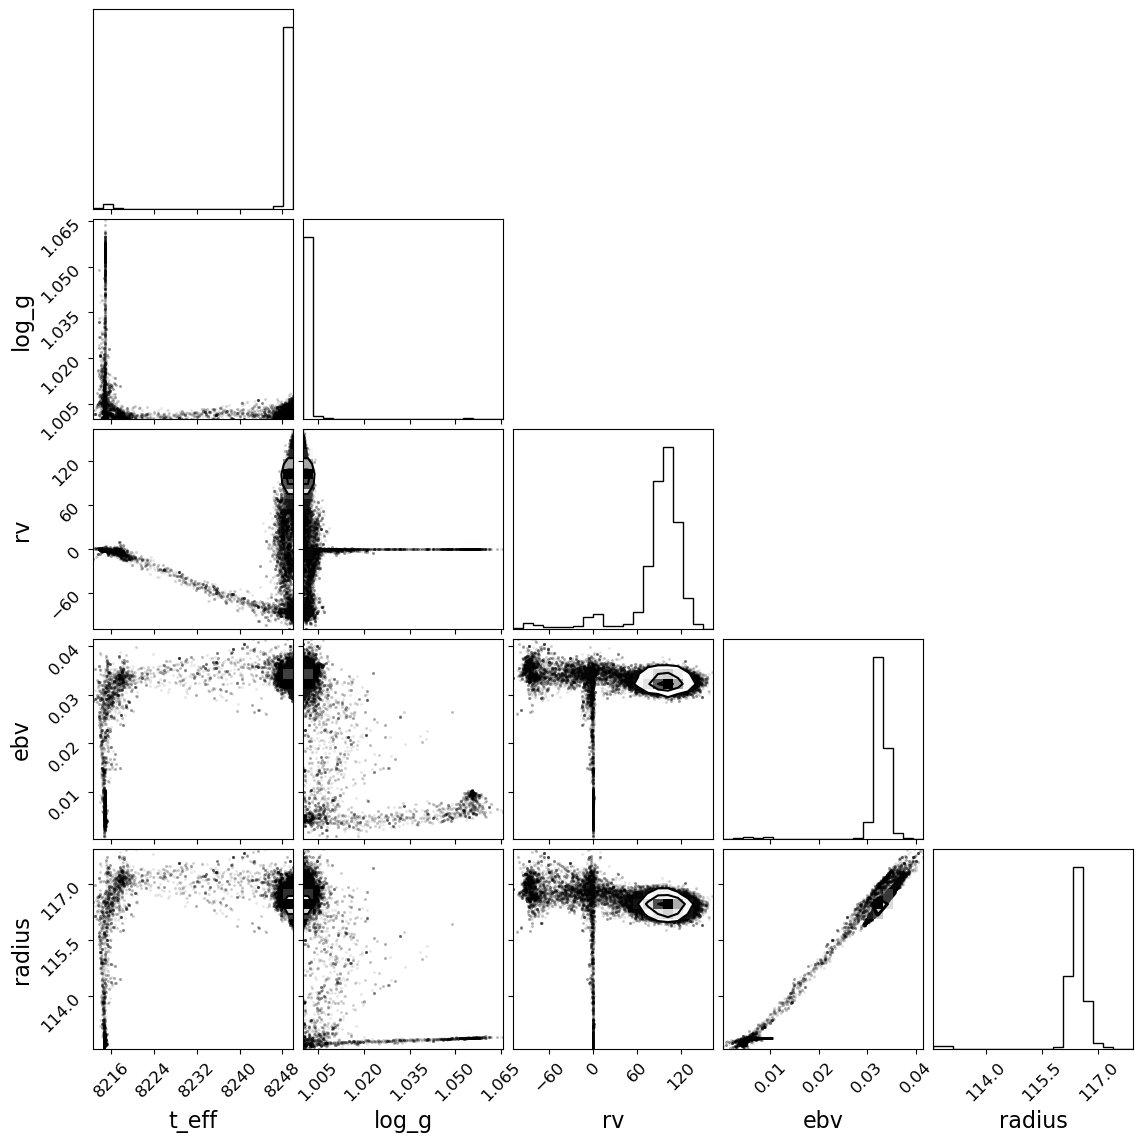

In [42]:
cornerplot(13, 5000) # woah multi modal!

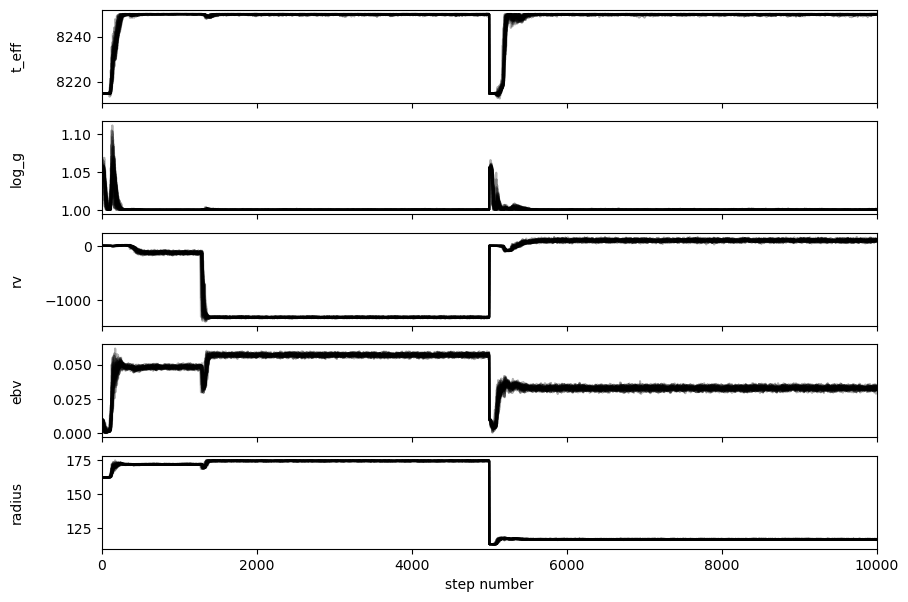

In [43]:
trace(13)

----------------
This graph is: hd269723_122722.fits and array 3 and named HD269723


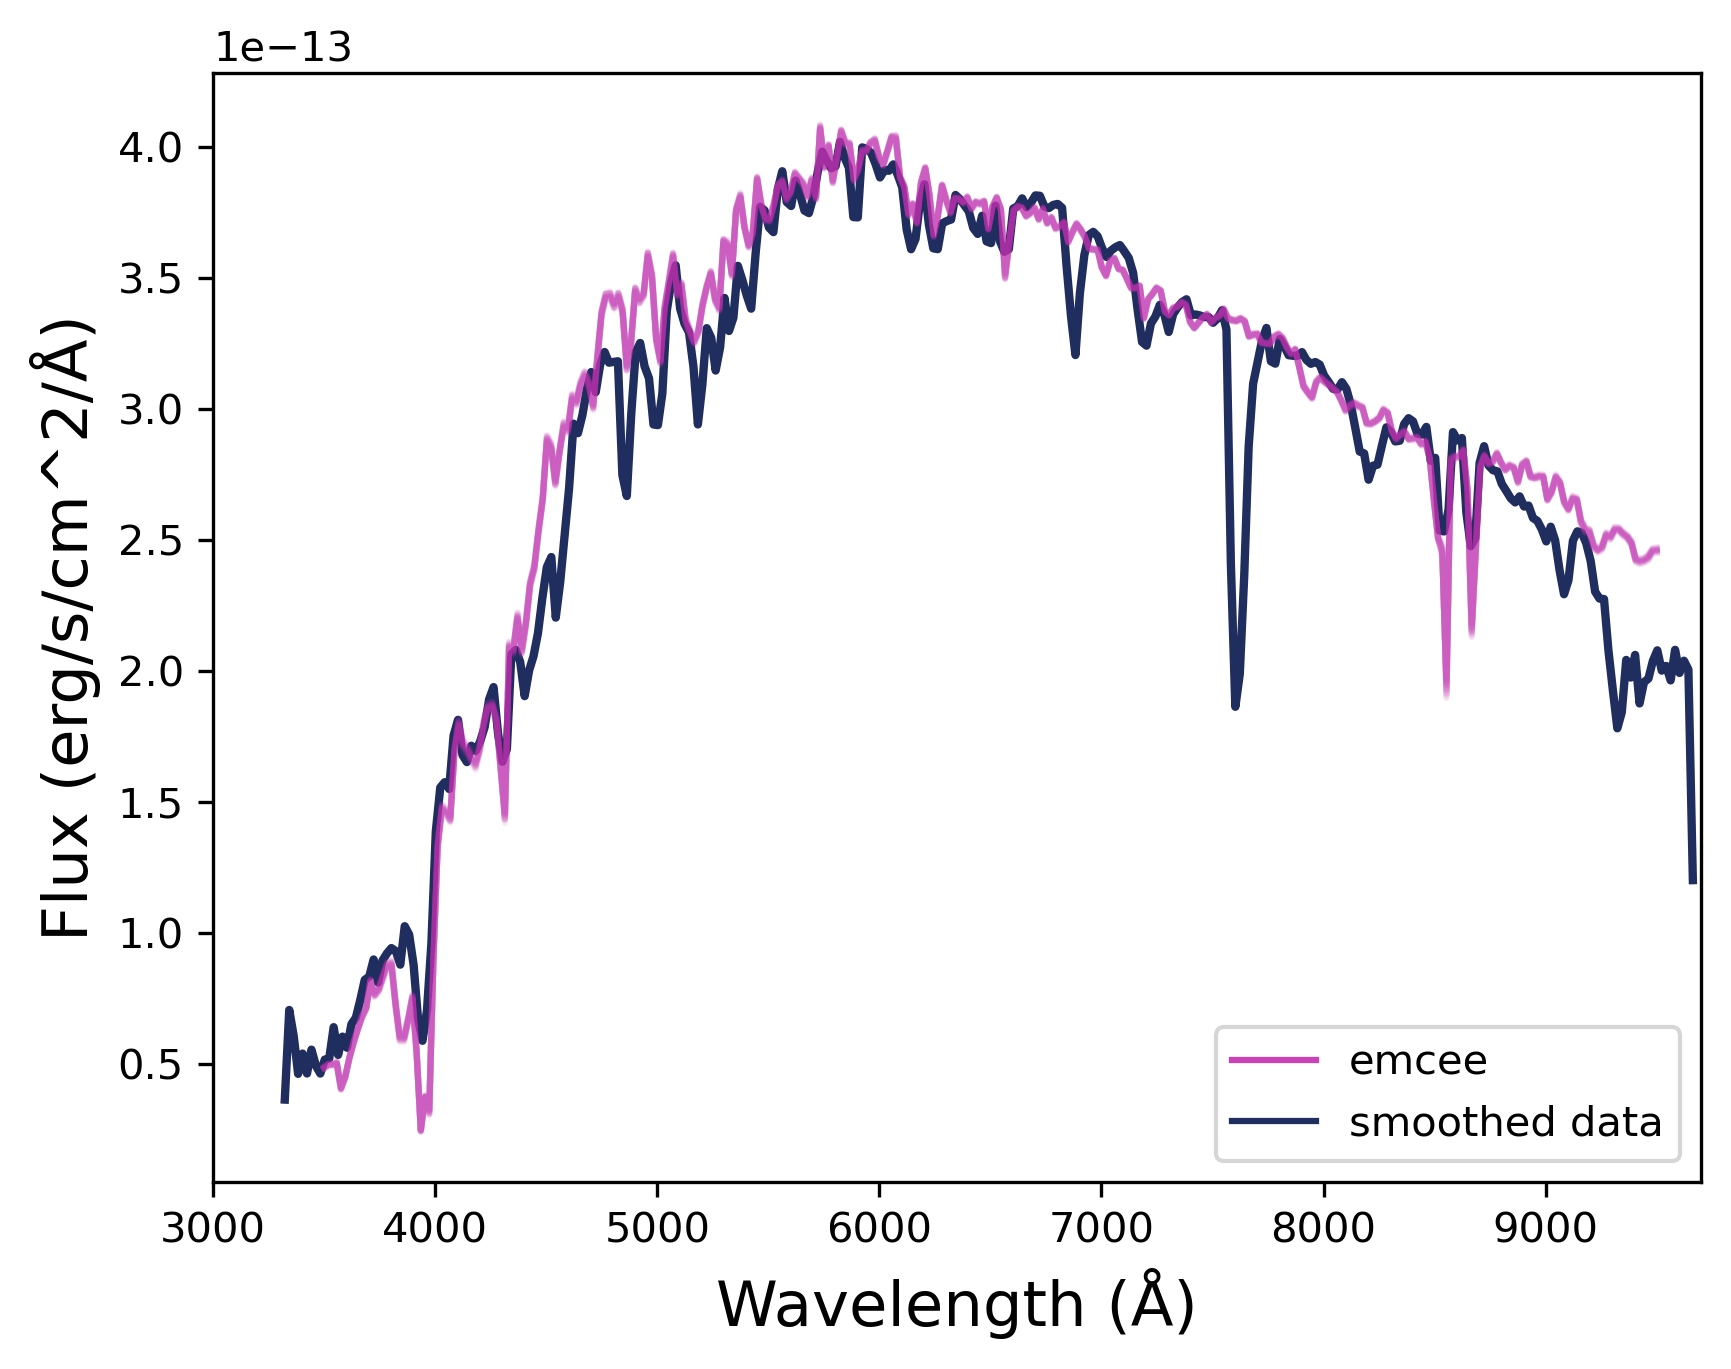

In [36]:
import cmasher as cmr
my_cmap = cmr.bubblegum
data_color = cmr.bubblegum(.1)
emcee_color = cmr.bubblegum(.6)

# # plot a posterior predictive plot for index 3
wavelength = np.linspace(3500, 9500, 318)
# postpred(wavelength, 13, 5100)
# #postpred(wavelength, 9)
postpred(wavelength, 3,1000)

In [35]:
mcvalues(13, toss=5100)

\mathrm{t_eff} = 8249.887_{-0.223}^{0.086}
\mathrm{log_g} = 1.000_{-0.000}^{0.000}
\mathrm{rv} = 96.942_{-19.959}^{16.372}
\mathrm{ebv} = 0.033_{-0.001}^{0.001}
\mathrm{radius} = 116.431_{-0.154}^{0.175}


In [26]:
mcvalues(24)

\mathrm{t_eff} = 7493.417_{-4.755}^{4.438}
\mathrm{log_g} = 2.999_{-0.001}^{0.000}
\mathrm{rv} = -465.798_{-13.775}^{12.541}
\mathrm{ebv} = 0.000_{-0.000}^{0.000}
\mathrm{radius} = 229.184_{-0.192}^{0.208}
